In [31]:
%load_ext autoreload
%autoreload 2
import datetime
import sys
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Object Detection and Sensor Fusion on the KITTI Dataset


## KITTI Dataset

The KITTI car dataset is a well-known dataset used in the field of computer vision, particularly for autonomous driving research. It is part of the KITTI Vision Benchmark Suite, which was created by the Karlsruhe Institute of Technology and the Toyota Technological Institute at Chicago. The dataset includes various types of data collected from a car driving around a mid-size city, in rural areas, and on highways.

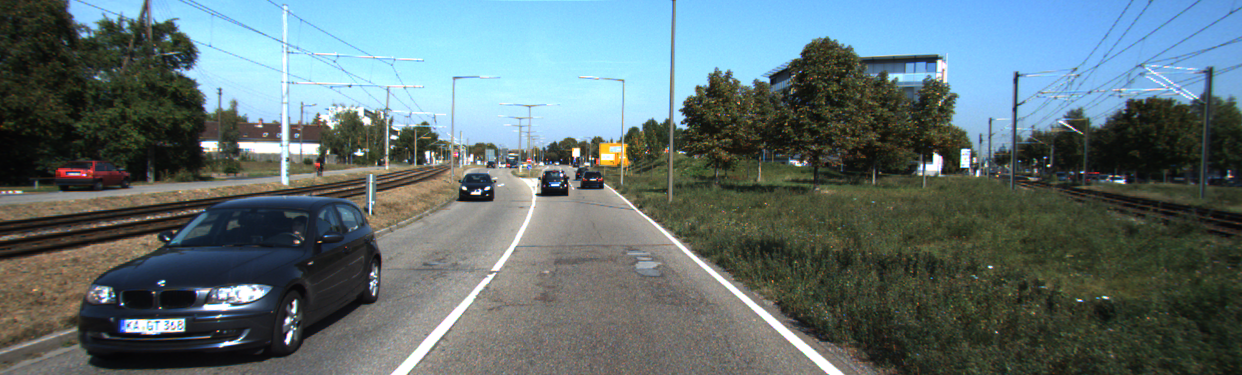

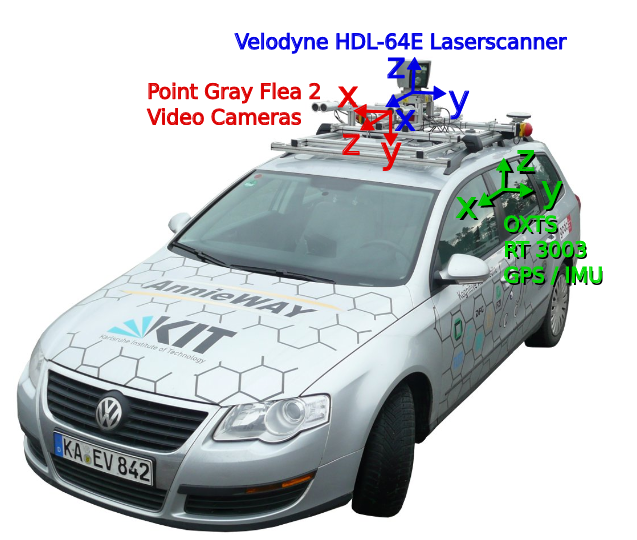

## Objective

In this notebook we would use the pruned SSD networks from the full_kitti branch to perform detection and fuse LiDAR point cloud on the detected objects.

In [32]:
from utils.datasets import *
from utils.parse_config import *
from utils.utils import *
from utils.models import *
from evaluate import *
from LiDAR_fusion import *

## Sensor Fusion

To perform sensor fusion, we need to project the point cloud from thier world coordinate system to the image plane. For this we first take the point clouds from the world coordinate frame to the camera coordinate frame using an $rotation$ and a $translation$ matrix. This *extrinsic* transformation matrix is applied on the homogenous coordinates of the point clouds:

$ {\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}}_C = \begin{bmatrix} \textbf{R} & T \\ 0^T & 1 \end{bmatrix} {\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}}_W$

Further, in order to project these points from the camera world to the image plane, we use the *intrinsic* transformation matrix:

$z_C \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} f_x & 0 & o_x & 0 \\ 0 & f_y & o_y & 0 \\ 0 & 0 & 1 & 0\end{bmatrix} {\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}}_C$

In [33]:
pc_path = './kitti-main/velodyne_reduced_pc'
pcs = {}
for file in os.listdir(pc_path):
    pc_array = bin_to_np_pcd(f'{pc_path}/{file}')
    pcs[file[:-4]] = pc_array
    
    break
pcs

{'004699': array([[ 2.06340008e+01,  1.87999994e-01,  9.07000005e-01],
        [ 7.59209976e+01,  2.28850002e+01,  2.89000010e+00],
        [ 7.55770035e+01,  2.30410004e+01,  2.88100004e+00],
        ...,
        [ 6.32200003e+00, -4.10000011e-02, -1.65100002e+00],
        [ 6.32600021e+00, -2.09999997e-02, -1.65199995e+00],
        [ 6.32499981e+00, -1.00000005e-03, -1.65100002e+00]])}

Now we follow the first step, i.e convert the points from cartesian to homogeneous form

In [34]:

pcs['004699'] = cart_to_homo(pcs['004699'])
print(pcs['004699'].shape)
#for pc_file in pcs.keys():
#    pcs[pc_file] = np.concatenate([pcs[pc_file], np.ones( shape=(len(pcs[pc_file]),1))], axis=-1)
#    print(f'{pc_file} shape:{pcs[pc_file].shape}')

(18903, 4)


Read the intrinsic and extrinsic transformation matrices from calib folder

$z_C \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = P . R_0 . R_T . {\begin{bmatrix} x \\ y \\ z \\ 1 \end{bmatrix}}_W$

where $R_T$ takes the point clouds from world coordinate to camera coordinate frame, $R_0$ is used in stereo vision to make images co-planar and $P$ takes the camera coordinates to image coordinates.

$R_T \in \textbf{R}^{4\text{x}4}$

$R_0 \in \textbf{R}^{4\text{x}4}$

$P \in \textbf{R}^{3\text{x}4}$

where our combined camera to image intrinsic matrix is represented as a product of the 2 matrices $P$ and $R_0$ respectively:  

$\begin{bmatrix} f_x & 0 & o_x & 0 \\ 0 & f_y & o_y & 0 \\ 0 & 0 & 1 & 0\end{bmatrix} = \begin{bmatrix} f & 0 & 0 & 0 \\ 0 & f & 0 & 0 \\ 0 & 0 & 1 & 0\end{bmatrix}\begin{bmatrix} m_x & 0 & \frac{o_x}{f} & 0 \\ 0 & m_y & \frac{o_y}{f} & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix}$

In [35]:
## Reading matrices from calib folder

proj_mats = read_proj_matrices(f'./kitti-main/calib/004699.txt')
proj_mats

{'P2': array([[7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
        [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
        [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]]),
 'R0_rect': array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
        [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
        [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Tr_velo_to_cam': array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
        [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
        [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
        [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])}

Now we can compute the image coordinates as ...
Y = P2@R0@RT@X, where Y = $\begin{bmatrix} \tilde{u} \\ \tilde{v} \\ \tilde{w} \end{bmatrix}$

And then finally $Y_{img} = \frac{1}{\tilde{w}} Y$

In [36]:

Y_img = project_pc_to_img('./kitti-main/calib/004699.txt', pcs['004699'])
        

In [37]:
Y_img

array([[604.7542241 , 145.76870844,  20.37298973],
       [391.80880807, 154.45310108,  75.68051492],
       [389.32049874, 154.43661479,  75.3364649 ],
       ...,
       [623.54464373, 369.04731992,   6.03500766],
       [621.14731297, 369.0673277 ,   6.03899967],
       [618.75806697, 369.00393945,   6.03801225]])

These represents points of the entire scene in 360 degrees. Next we need to exclude the points that do not appear in the camera FOV

In [38]:
proj_points = projected_pc_to_camera_fov('./kitti-main/images_orig/004699.png', Y_img)
print(proj_points.shape)        

(18903, 3)


Now we are ready to project the point clouds on to the image!

Img shape before cv2: (375, 1242, 3)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 19,  18,  53],
        [ 20,  17,  29],
        [ 15,  19,  31]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 30,  31,  57],
        [ 28,  33,  43],
        [ 22,  26,  53]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 41,  63, 106],
        [ 36,  46,  85],
        [ 21,  27,  87]],

       ...,

       [[ 79,  77,  76],
        [ 78,  76,  73],
        [ 80,  76,  70],
        ...,
        [ 77,  78,  78],
        [ 77,  77,  78],
        [ 77,  76,  78]],

       [[  2, 255,  12],
        [ 79,  77,  67],
        [  2, 255,  12],
        ...,
        [ 77,  76,  74],
        [ 78,  76,  75],
        [ 79,  76,  74]],

       [[ 54,  72,  76],
        [  2, 255,  12],
        [ 40,  53,  63],
        ...,
        [ 73,  73,  74],
        [ 73,  72,  74],
        [ 72,  72,  74]]

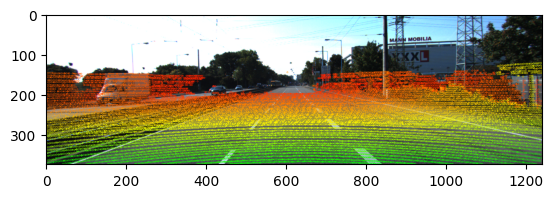

In [39]:

import matplotlib.pyplot as plt
import cv2

plot_proj_pc_on_img('kitti-main/images_orig/004699.png', proj_points, img_size=375)

Now we would use an Object detection model to first detect the bounding box and then fuse the LiDAR point cloud on it 

Img shape before cv2: (352, 352, 3)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [112, 127,  70],
        [ 90, 107,  49],
        [ 78,  64,  48]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 96,  85,  62],
        [ 93, 118,  72],
        [113,  93,  67]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 66,  75,  46],
        [ 68, 125,  89],
        [127, 112,  78]],

       ...,

       [[ 86,  82,  87],
        [ 90,  78,  90],
        [ 84,  81, 101],
        ...,
        [ 74,  71,  85],
        [ 14, 255,   0],
        [ 74,  67,  66]],

       [[ 88,  81,  99],
        [ 88,  98,  95],
        [ 81,  96,  75],
        ...,
        [ 14, 255,   0],
        [ 71,  72,  67],
        [ 14, 255,   0]],

       [[ 62,  79,  98],
        [ 73,  93,  92],
        [ 74,  87,  79],
        ...,
        [ 93,  70,  70],
        [ 75,  71,  84],
        [ 74,  91,  89]]

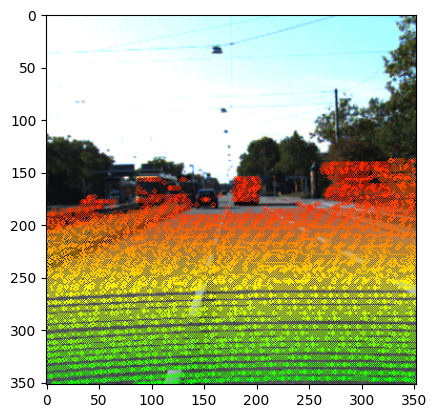

In [40]:
from PIL import Image
from LiDAR_fusion import *

img = Image.open(f'kitti-main/images_orig/002014.png')
pc = np.load(f'kitti-main/pcs_processed/002014.npy')

pc = cart_to_homo(pc)
proj_points = project_pc_to_img(f'kitti-main/calib_processed/002014.txt', pc, scale=352/375)

plot_proj_pc_on_img(f'kitti-main/images_processed/002014.png', proj_points)

# SSD

The [SSD](https://arxiv.org/pdf/1512.02325) (Single Shot MultiBox Detector)  is a popular object detection model designed for high speed and accuracy in detecting objects within images. It is called "Single Shot" because it makes predictions directly from feature maps without requiring a separate region proposal stage, allowing it to perform detection in a single pass. The code was refactored from the [amdegroot](https://github.com/amdegroot/ssd.pytorch). 


## Multiple Aspect Ratios and Scales
SSD predicts bounding boxes and class scores for objects at multiple scales and aspect ratios from feature maps of different resolutions. This helps in detecting objects of various sizes.

![image.png](./notebook_figs/SSD.png)


## Network and Loss
SSD consists of only convolutional layers to predict both object classes and bounding box offsets from feature maps. It employs a combination of localization loss (e.g., smooth L1 loss) for bounding box regression and confidence loss (e.g., softmax loss) for class prediction. As given in the [paper](https://arxiv.org/pdf/1512.02325) we use VGG16 as the backbone network and additional conv layers (details in the config file) for the complete network.

![image.png](./notebook_figs/Network%20SSD.png)


In [41]:
from utils import models

opt = dict()
opt["image_folder"] = "kitti-main/test.txt"
opt["model_def"] = "config/ssd-kitti_0.32.cfg"
opt["weights_path"] = "SSD_compressed_0.32.pth"
opt["class_path"] = "kitti-main/classes.names"
opt["batch_size"] = 1
opt["n_cpu"] = 8
opt["img_size"] = 300
opt["conf_thres"] = 0.8
opt["nms_thres"] = 0.4

for key in opt:
    print(f"{key}: {opt[key]}")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = load_classes(opt["class_path"])  # Extracts class labels from file

dataloader = DataLoader(ListDataset(opt["image_folder"], img_size=opt["img_size"], transform=None,
                                    num_classes=int(len(classes)), multiscale=False),
                        batch_size=opt["batch_size"],
                        shuffle=False,
                        num_workers=opt["n_cpu"],
                        )

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

print("\nPerforming object detection:")
prev_time = time.time()

os.makedirs("output_SSD_fused", exist_ok=True)

# Set up model
model = SSD(opt["model_def"], num_classes=7).to(device)

# Load checkpoint weights
model.load_state_dict(torch.load(opt["weights_path"], map_location=torch.device("cuda:0")))

# Set in evaluation mode
model.eval()

image_folder: kitti-main/test.txt
model_def: config/ssd-kitti_0.32.cfg
weights_path: SSD_compressed_0.32.pth
class_path: kitti-main/classes.names
batch_size: 1
n_cpu: 8
img_size: 300
conf_thres: 0.8
nms_thres: 0.4

Performing object detection:


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(38, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(38, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(76, 76, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(76, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(150, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU(inpla

In [44]:
imgs = [] #Stores images
imgs_paths = []  # Stores image paths
img_detections = []  # Stores detections for each image index
img_proj_pcs = [] #Stores point cloud projections over all detected bounding boxes

prev_time = time.time()
for batch_i, (img_paths, input_imgs, targets) in enumerate(dataloader):
    if batch_i > 10: break
    # Configure input
    
    input_imgs = Variable(input_imgs.type(Tensor))
    img_name = img_paths[0].split('/')[-1][:-4]
    # Get detections
    with torch.no_grad():
        detections = model(input_imgs, 'eval')
        detections = non_max_suppression(detections, conf_thres=opt['conf_thres'], nms_thres=opt['nms_thres'])
        
        ## Loading the projected point cloud over the image
        points = np.load(f'kitti-main/pcs_processed/{img_name}.npy')
        proj_points = project_pc_to_img(f'kitti-main/calib_processed/{img_name}.txt', cart_to_homo(points), scale=300/375)
        proj_points_bb = None
        
        if detections[0] is not None:
            detections_ = detections[0].detach().numpy()
            ## Gathering all point clouds present inside bounding boxes
            for detection in detections_:
                x1, y1, x2, y2, conf, cls_conf, cls_pred = detection
                points_inside,_ = proj_pcs_inside(detection[:4], proj_points)
                if proj_points_bb is None:
                    proj_points_bb = points_inside
                else:
                    proj_points_bb = np.concatenate([proj_points_bb, points_inside], axis=0)
            #proj_points_bb = proj_points
    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.append(input_imgs)
    imgs_paths.append(img_paths)
    img_detections.extend(detections) #(num_classes, top_k, 5)
    img_proj_pcs.append(proj_points_bb)

    
print(f'len of imgs: {len(imgs)}')

precision, recall, AP, f1, ap_class = evaluate(
                    model,
                    path=opt['image_folder'],
                    iou_thres=0.5,
                    conf_thres=0.4,
                    nms_thres=0.5,
                    img_size=300,
                    batch_size=4,
                    num_classes=7,
                    model_type='ssd'
                )

print(f'Model Precision: {precision.mean():.2f}, Recall: {recall.mean():.2f}, AP: {AP.mean():.2f}, f1: {f1.mean():.2f}')


	+ Batch 0, Inference Time: 0:00:00.553177
	+ Batch 1, Inference Time: 0:00:00.023484
	+ Batch 2, Inference Time: 0:00:00.023304
	+ Batch 3, Inference Time: 0:00:00.019728
	+ Batch 4, Inference Time: 0:00:00.017351
	+ Batch 5, Inference Time: 0:00:00.016834
	+ Batch 6, Inference Time: 0:00:00.028212
	+ Batch 7, Inference Time: 0:00:00.020377
	+ Batch 8, Inference Time: 0:00:00.017694
	+ Batch 9, Inference Time: 0:00:00.016572
	+ Batch 10, Inference Time: 0:00:00.020814
len of imgs: 11


Computing AP: 100%|██████████| 7/7 [00:00<00:00, 678.14it/s]

Model Precision: 0.62, Recall: 0.79, AP: 0.73, f1: 0.69


Number of detections processed: 11

Saving images:
(0) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/007423.png',)'
tensor([ 48.8515, 143.5255,  84.5566, 167.8107,   0.9963,   1.0000,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 1.00000
(1) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/021615.png',)'
tensor([169.8357, 149.8578, 229.5132, 177.1190,   0.9283,   1.0000,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 0.99999
(2) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV3_SSD/kitti-main/images/test/017164.png',)'
tensor([ 21.3475, 134.0416, 108.0687, 166.2927,   0.9112,   0.9998,   0.0000]) 300 (300, 300)
	+ Label: Car, Conf: 0.99979
(3) Image: '('/home/kartik/Desktop/ADS/Softwareentwick 950733395 (S24)_2024072_1714/04 - Detection (14.05)/YOLOV

/tmp/ipykernel_6306/3198159734.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

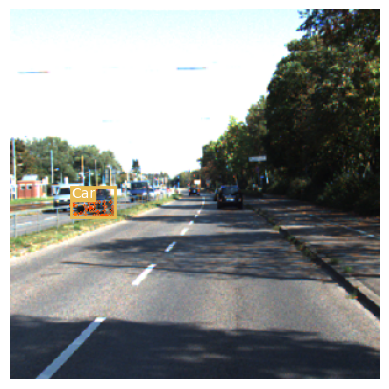

<Figure size 640x480 with 0 Axes>

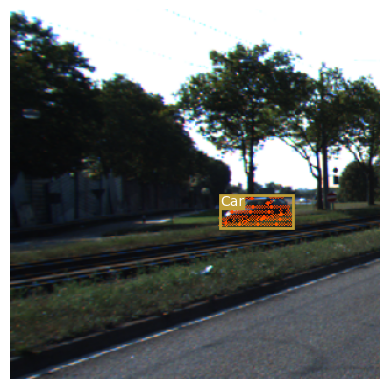

<Figure size 640x480 with 0 Axes>

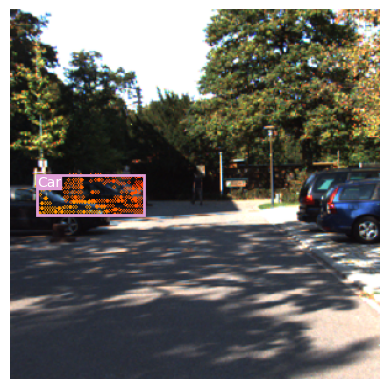

<Figure size 640x480 with 0 Axes>

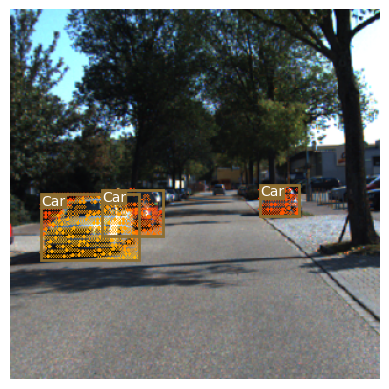

<Figure size 640x480 with 0 Axes>

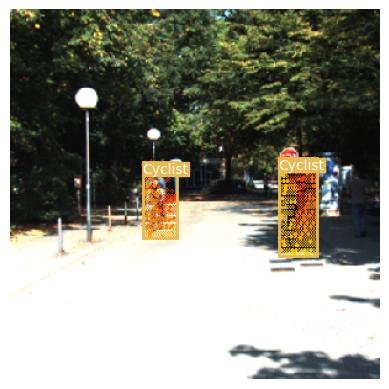

<Figure size 640x480 with 0 Axes>

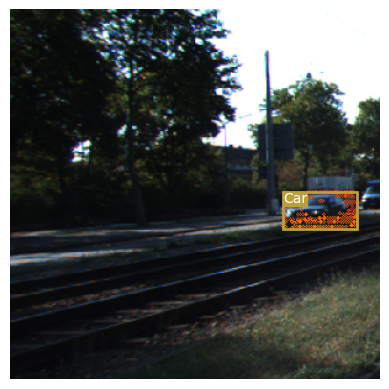

<Figure size 640x480 with 0 Axes>

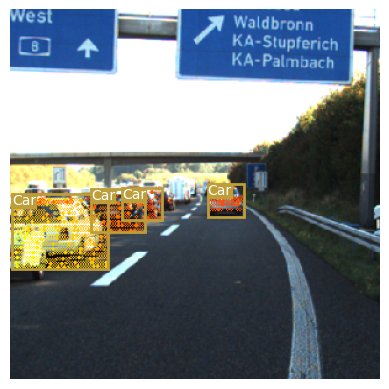

<Figure size 640x480 with 0 Axes>

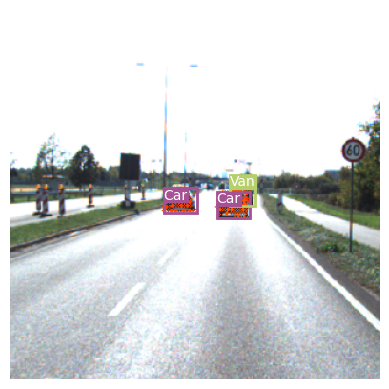

<Figure size 640x480 with 0 Axes>

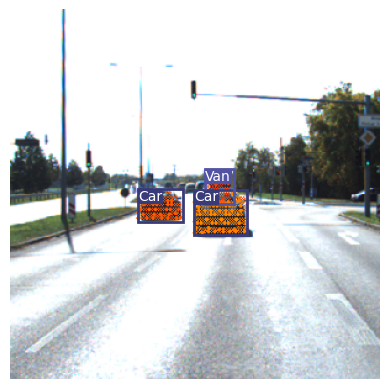

<Figure size 640x480 with 0 Axes>

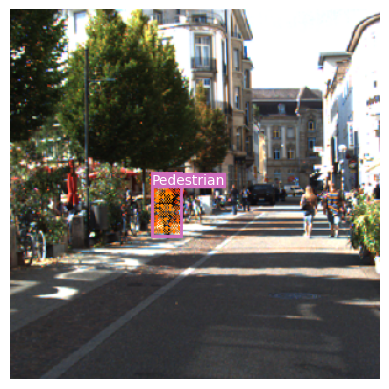

<Figure size 640x480 with 0 Axes>

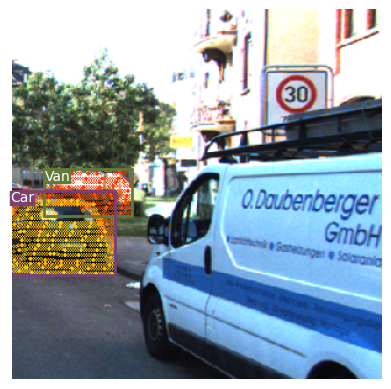

In [45]:
print(f'Number of detections processed: {len(img_detections)}')
# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections
for img_i, (img_, path, detections, proj_points_bb) in enumerate(zip(imgs, imgs_paths, img_detections, img_proj_pcs)):

    print("(%d) Image: '%s'" % (img_i, path))
    path = path[0]
    img_ = img_.squeeze(0)

    img = np.transpose(img_.detach().cpu().numpy(), (1,2,0))
    if proj_points_bb is not None:
        img = plot_proj_pc_on_img_(img, proj_points_bb)
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )
            


    # Save generated image with detections
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(path).split(".")[0]
    
    output_path = os.path.join("output_SSD_fused", f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.imshow(img)
    #plt.close()